# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]    # what does ~ mean???? it's "not"!
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


In [6]:
len(critics.rtid.unique())

1921

In [7]:
critics.rtid.unique().size

1921

In [4]:
critics.describe()

,imdb,rtid
count,1.556100e+04,1.556100e+04
mean,1.566739e+05,5.704018e+07
std,1.588589e+05,1.829727e+08
min,1.344200e+04,1.100000e+01
25%,9.905200e+04,1.130600e+04
50%,1.163670e+05,1.336900e+04
75%,1.375230e+05,1.641600e+04
max,1.190539e+06,7.710318e+08


In [7]:
critics.columns

Index(['critic', 'fresh', 'imdb', 'publication', 'quote', 'review_date', 'rtid', 'title'], dtype='object')

In [9]:
critics.size


124488

In [13]:
critics.columns.unique().size

8

In [21]:
critics.head(20)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story
6,Michael Booth,fresh,114709,Denver Post,"As Lion King did before it, Toy Story revived ...",2007-05-03,9559,Toy story
7,Geoff Andrew,fresh,114709,Time Out,The film will probably be more fully appreciat...,2006-06-24,9559,Toy story
8,Janet Maslin,fresh,114709,New York Times,Children will enjoy a new take on the irresist...,2003-05-20,9559,Toy story
9,Kenneth Turan,fresh,114709,Los Angeles Times,Although its computer-generated imagery is imp...,2001-02-13,9559,Toy story
10,Susan Wloszczyna,fresh,114709,USA Today,How perfect that two of the most popular funny...,2000-01-01,9559,Toy story


In [23]:
grp.count().head()

,fresh,imdb,publication,quote,review_date,rtid,title
critic,,,,,,,
A.D. Murphy,13,13,13,13,13,13,13
A.H. Weiler,17,17,17,17,17,17,17
A.O. Scott,19,19,19,19,19,19,19
Aaron Hillis,2,2,2,2,2,2,2
Abel Green,5,5,5,5,5,5,5


In [25]:
grp.critic.count().head()

critic
A.D. Murphy     13
A.H. Weiler     17
A.O. Scott      19
Aaron Hillis     2
Abel Green       5
Name: critic, dtype: int64

In [27]:
grp.fresh.mean().head()

critic
A.D. Murphy     1.000000
A.H. Weiler     0.705882
A.O. Scott      0.368421
Aaron Hillis    1.000000
Abel Green      1.000000
Name: fresh, dtype: float64

In [29]:
means[counts > 100].head()   #meaning?????? aveg of all the revirerw s who have reviewd more than 100 movies

critic
Bosley Crowther    0.695035
Dave Kehr          0.591716
Derek Adams        0.615894
Desson Thomson     0.588235
Edward Guthmann    0.638655
Name: fresh, dtype: float64

In [10]:
df.columns

Index(['critic', 'fresh', 'imdb', 'publication', 'quote', 'review_date', 'rtid', 'title'], dtype='object')

In [13]:
df.fresh.value_counts()

True     9482
False    6079
Name: fresh, dtype: int64

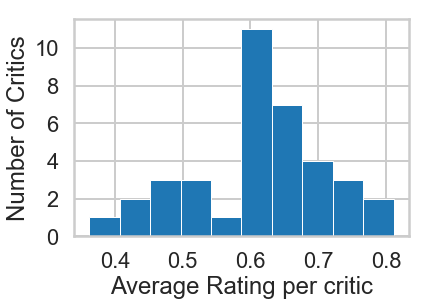

In [4]:
df = critics.copy()       #makes a shallow copy so the original data is intact
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')    # groups by the critics (the individuals)
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

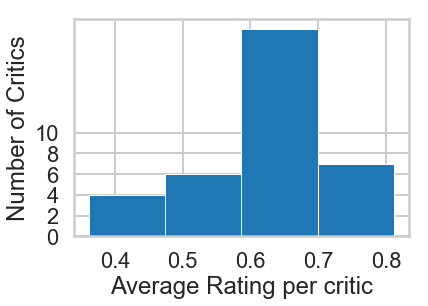

In [31]:
means[counts > 100].hist(bins=4, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [32]:
df = df.drop(['large_counts'], axis=1)

In [33]:
df.columns

Index(['critic', 'fresh', 'imdb', 'publication', 'quote', 'review_date', 'rtid', 'title'], dtype='object')

In [19]:
print(means.head(15))

critic
A.D. Murphy                1.000000
A.H. Weiler                0.705882
A.O. Scott                 0.368421
Aaron Hillis               1.000000
Abel Green                 1.000000
Achy Obejas                0.000000
Adam Graham                0.166667
Adam Markovitz             0.000000
Akiva Gottlieb             0.000000
Al Brumley                 0.333333
Al Finestone               1.000000
Alan Scherstuhl            1.000000
Alfred Rushford Greason    1.000000
Alissa Simon               0.000000
Allan Johnson              1.000000
Name: fresh, dtype: float64


<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

+ The average ratings per critic seems to have it's highest occurance at 0.6, meaning that a lot of critics ranked 0.6 on average. 
+ bi modal it has 2 peaks
+ It almost looks normal, except for a dip right before the max value. This will be washed away if we reduce the number of bins

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
#x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))
print(x)
# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())  #Array mapping from feature integer indices to feature name
# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 1)	1
  (1, 3)	1
  (2, 0)	3
  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 1)	1
  (1, 3)	1
  (2, 0)	3

Words for each feature:
['hop', 'off', 'on', 'pop']


In [27]:
x =x.tocsc() 
x

<3x4 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Column format>

In [73]:
print(vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=49, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


In [6]:
def make_xy(critics, vectorizer=None):  # STILL QUESTION
    #Your code here    
    if vectorizer is None:     # what if we say 0 ?????? None means Null. 0 is an integer 
        vectorizer = CountVectorizer()
#when to know to have CountVectorizer(min_df=0) and when not ot have min_df???? it is set to zero by default
    X = vectorizer.fit_transform(critics.quote) #fits and transforms??? transform to the numeric representation 
#fit_transform() joins these two steps and is used for the initial fitting of parameters on the training set x, 
#but it also returns a transformed x′. Internally, it just calls first fit() and then transform() on the same data.
    X = X.tocsc()  # some versions of sklearn return COO format #compressed column sparse 
    #Return a copy of this matrix in Compressed Sparse Column format ????????????????
    y = (critics.fresh == 'fresh').values.astype(np.int) # if fresh it becomes 1 and it's rotten it becomes 0. 
    return X, y
X, y = make_xy(critics)

In [74]:
critics.shape

(15561, 8)

In [50]:
print(X,y)  #row (row number of the quote) , col (the first word of the first col), and actual value of the count(frequnccy)

  (1028, 0)	1
  (3215, 0)	1
  (4740, 0)	1
  (4741, 0)	1
  (8722, 0)	2
  (8820, 0)	1
  (12118, 0)	1
  (4031, 1)	1
  (74, 2)	1
  (76, 2)	1
  (3653, 2)	1
  (4031, 2)	1
  (8023, 2)	1
  (10704, 2)	1
  (13425, 2)	1
  (13435, 2)	1
  (13668, 2)	1
  (13693, 2)	1
  (8647, 3)	1
  (369, 4)	1
  (24, 5)	1
  (65, 5)	1
  (472, 5)	1
  (625, 5)	1
  (731, 5)	1
  :	:
  (14548, 22402)	1
  (14551, 22402)	1
  (958, 22403)	1
  (10209, 22403)	1
  (6804, 22404)	1
  (8594, 22405)	1
  (14697, 22406)	1
  (6465, 22407)	1
  (4134, 22408)	1
  (8145, 22408)	1
  (4471, 22409)	1
  (4477, 22409)	1
  (4478, 22409)	1
  (4476, 22410)	1
  (8847, 22411)	1
  (1076, 22412)	1
  (3126, 22412)	1
  (3128, 22412)	1
  (9252, 22412)	1
  (2774, 22413)	1
  (3360, 22414)	1
  (5930, 22414)	1
  (10457, 22414)	1
  (4473, 22415)	1
  (8518, 22416)	1 [1 1 1 ... 1 1 1]


In [56]:
X.shape[1]   #(, this one) number of columns  IS THIS SHOWING THE NUMBER OF UNIQUE WORDS across all the doc??yes 

22417

In [57]:
X.shape[0]  #X.shape is (n,m). So X.shape[0] is n   (this one, )  number of rows

15561

In [58]:
len(y)

15561

In [59]:
print(y)

[1 1 1 ... 1 1 1]


In [36]:
X.shape

(15561, 22417)

In [62]:
print(X)

  (1028, 0)	1
  (3215, 0)	1
  (4740, 0)	1
  (4741, 0)	1
  (8722, 0)	2
  (8820, 0)	1
  (12118, 0)	1
  (4031, 1)	1
  (74, 2)	1
  (76, 2)	1
  (3653, 2)	1
  (4031, 2)	1
  (8023, 2)	1
  (10704, 2)	1
  (13425, 2)	1
  (13435, 2)	1
  (13668, 2)	1
  (13693, 2)	1
  (8647, 3)	1
  (369, 4)	1
  (24, 5)	1
  (65, 5)	1
  (472, 5)	1
  (625, 5)	1
  (731, 5)	1
  :	:
  (14548, 22402)	1
  (14551, 22402)	1
  (958, 22403)	1
  (10209, 22403)	1
  (6804, 22404)	1
  (8594, 22405)	1
  (14697, 22406)	1
  (6465, 22407)	1
  (4134, 22408)	1
  (8145, 22408)	1
  (4471, 22409)	1
  (4477, 22409)	1
  (4478, 22409)	1
  (4476, 22410)	1
  (8847, 22411)	1
  (1076, 22412)	1
  (3126, 22412)	1
  (3128, 22412)	1
  (9252, 22412)	1
  (2774, 22413)	1
  (3360, 22414)	1
  (5930, 22414)	1
  (10457, 22414)	1
  (4473, 22415)	1
  (8518, 22416)	1


In [63]:
print(X[0])

  (0, 891)	2
  (0, 1767)	1
  (0, 2784)	1
  (0, 3248)	1
  (0, 4003)	1
  (0, 4386)	1
  (0, 5251)	1
  (0, 6494)	1
  (0, 6856)	1
  (0, 9950)	1
  (0, 10176)	1
  (0, 10555)	1
  (0, 10566)	1
  (0, 13657)	1
  (0, 14940)	1
  (0, 17231)	1
  (0, 17943)	1
  (0, 18252)	1
  (0, 18757)	1
  (0, 18904)	1
  (0, 19914)	1
  (0, 21732)	1
  (0, 22330)	1


In [64]:
print(X[1])

  (0, 3835)	1
  (0, 10463)	1
  (0, 12878)	1
  (0, 19917)	1
  (0, 22292)	1


In [68]:
X.shape   # what does this number of rows and columns mean?

(15561, 21740)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) #test_size=0.33, random_state=42
clf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None) #(alpha=1.0, fit_prior=True, class_prior=None) alpha = 0 is for no smoothing 
model = clf.fit(X_train, y_train)
preds = clf.predict(X_test)    # STILL QUESTION about predict. should I comment or not????
# I am using  score so it predicts as well and then checks the acuracy with the actual values

# Evaluate accuracy
print('Accuracy on train data: ' + str(model.score(X_train, y_train)))
print('Accuracy on test data: ' + str(model.score(X_test, y_test)))

#print(accuracy_score(y_test, preds))

Accuracy on train data: 0.8650385604113111
Accuracy on test data: 0.7779491133384734


+ Apparently, overfitting means the train and test are having a huge difference 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [8]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt


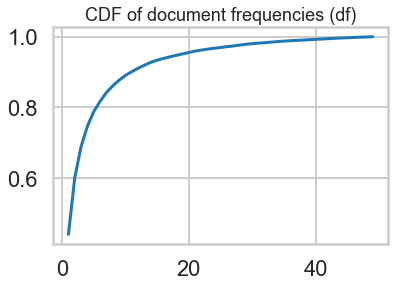

In [9]:
vectorizer = CountVectorizer(min_df=1)  # comment this latter 
X, y = make_xy(critics, vectorizer)
dfs = []
for i in range(1,50):
    vectorizer = CountVectorizer(max_df=i)
    X,y = make_xy(critics,vectorizer=vectorizer)  
    #what does this make_xy do exactly? you get the features from the text data 
    dfs.append(X.shape[1])
dfs_percent = [df/X.shape[1] for df in dfs]
plt.plot(range(1,50),dfs_percent)
plt.title('CDF of document frequencies (df)', fontsize=18)
plt.show()

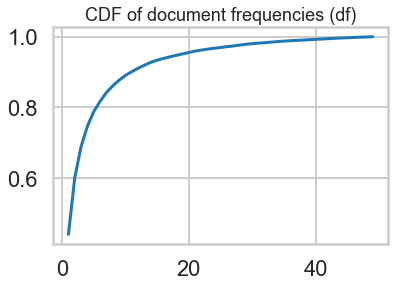

In [8]:
dfs = []
for i in range(1,50):
    vectorizer = CountVectorizer(max_df=i)
    X,y = make_xy(critics,vectorizer=vectorizer)  
    #what does this make_xy do exactly? you get the features from the text data 
    dfs.append(X.shape[1])
dfs_percent = [df/X.shape[1] for df in dfs]  #list comprehension: [ expression for item in list if conditional ]
plt.plot(range(1,50),dfs_percent)
plt.title('CDF of document frequencies (df)', fontsize=18)
plt.show()

Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?

+ This min_df = 5 and max_df = 40 

In [66]:
print(dfs_percent) #the y values 

[0.4409383624655014, 0.6014259429622815, 0.6894204231830727, 0.747148114075437, 0.7884084636614536, 0.8174793008279668, 0.8423183072677093, 0.8611775528978841, 0.8772309107635694, 0.890754369825207, 0.9011959521619135, 0.911177552897884, 0.9195032198712052, 0.9276908923643055, 0.9336246550137994, 0.9387304507819687, 0.9432382704691812, 0.9472861085556578, 0.9515639374425023, 0.9553357865685372, 0.9594296228150874, 0.9624195032198712, 0.9650413983440662, 0.9675252989880405, 0.9695032198712051, 0.9719871205151794, 0.9738730450781968, 0.9764029438822447, 0.9787488500459982, 0.9804047838086477, 0.9819227230910763, 0.9832566697332107, 0.984820607175713, 0.9864305427782889, 0.9876724931002759, 0.9887764489420423, 0.9896964121435142, 0.9906163753449863, 0.9915823367065317, 0.9925942962281509, 0.99360625574977, 0.9945262189512419, 0.9955381784728611, 0.9964121435142594, 0.9971941122355106, 0.9979760809567617, 0.9988040478380865, 0.9993100275988961, 1.0]


In [67]:
len(dfs)

49

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [10]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):    #where can I get scorefunc documentation ??? it s a dummy name 
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data (test data)
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [11]:
def log_likelihood(clf, x, y):    #explain plssss   We use the log-likelihood as the score here in scorefunc
    prob = clf.predict_log_proba(x)   #Return log-probability estimates for the test vector x
    rotten = y == 0 #(if y is equal to 0) and rottten is a list 
    fresh = ~rotten   # why do we need to repeat this again? 
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()
#   ,0 get me the first column from the list of probabilities 
# meaning of the prob[ , ] ideially as max as possible 

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [75]:
critics.shape[0]

15561

In [12]:
from sklearn.model_selection import train_test_split 
#meaning? the split func splits the train 70% and features are the rows?!!! 
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)  #critics.shape[0] is the row numbers
#which rows in the data is the train data 
mask = np.zeros(critics.shape[0], dtype=np.bool)  #what does this zeros function do? 
# it creates a list of zero rows  to true (training data) and the rest to false (test data)
mask[itest] = True  # np.zaros(shape, dtype=float, order='C') = Array of zeros with the given shape, dtype, and order

C:\Users\Nazanin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [31]:
itest

[13733,
 6083,
 9011,
 5982,
 10390,
 2512,
 7309,
 14166,
 2031,
 2052,
 5109,
 10893,
 3812,
 9170,
 13138,
 4169,
 6164,
 3346,
 8932,
 101,
 13548,
 11095,
 6251,
 13264,
 12817,
 8403,
 1931,
 274,
 1398,
 13936,
 15243,
 10586,
 14404,
 495,
 10616,
 2772,
 8475,
 3386,
 12797,
 8642,
 4304,
 7217,
 10051,
 1389,
 514,
 8962,
 117,
 6272,
 5743,
 1383,
 12529,
 2237,
 5599,
 12245,
 2470,
 1509,
 15529,
 8232,
 2293,
 5662,
 1854,
 9688,
 7085,
 5501,
 2867,
 7558,
 2285,
 1825,
 14158,
 8967,
 12383,
 8325,
 6389,
 3436,
 7789,
 7666,
 897,
 3344,
 7409,
 4179,
 11572,
 11525,
 14838,
 5510,
 6415,
 8669,
 2529,
 15102,
 10553,
 5742,
 15503,
 13285,
 5397,
 3195,
 168,
 79,
 656,
 14859,
 3901,
 4376,
 5205,
 7706,
 10727,
 1906,
 13489,
 13494,
 12464,
 54,
 13446,
 6984,
 541,
 8044,
 14781,
 14019,
 11404,
 12786,
 3024,
 15279,
 6816,
 4602,
 4828,
 5016,
 3817,
 7602,
 7714,
 10917,
 5652,
 7646,
 6221,
 12252,
 10006,
 8811,
 11773,
 5377,
 1405,
 15394,
 8832,
 2826,
 13

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

+ The model is using the log loss as scoring rule. In the documentation, the log loss is defined "as the negative log-likelihood of the true labels given a probabilistic classifier’s predictions". 

+ Since log-likelihood is indeed negative, its negative will be a positive number.

+ Here, α is often referred to as the "learning rate", and in many problems, is selected without strong justification (i.e. empirically seems to work well, but no proof that is optimal). Choosing a poor learning rate can lead to very poor performance.

+ This means that as our sample size gets larger, we take larger steps when using the unnormalized log-likelihood, even when we are the same distance away from the optimal solution. With that in mind, we can see that it should be impossible to pick an α that is optimal for all sample sizes.

+ The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. A value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.


+ #if alpha is big then the model overfits 

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = None # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    # your turn

In [14]:
#Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` 
#you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over    
alphas = [.1, 1, 5, 10, 50]
best_min_df = 5 #[0.01, 0.05, 0.1]  # YOUR TURN: put your value of min_df here.  I am guessing we need to set min = 8???

#Find the best value for alpha and min_df, and the best classifier
best_alpha = 0   # can we set them to 0 than None???? isnce alpha would never be 0 None or 0 are interchangable
#best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    #for min_df in min_dfs:
    vectorizer = CountVectorizer(min_df= best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]  
    ytrainthis = ythis[mask]
        # your turn
    clf = MultinomialNB(alpha=alpha)
    score = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood) 
    print('score: ' + str(score) + 'and aplha: ' + str(alpha))
    if score > maxscore:
        maxscore = score
        best_alpha = alpha  #, best_min_df  , , min_df
#log_likelihood(cv_score, x, y)  
#log_likelihood(clf, x, y)
        
#print('The value of best min_df: ' + str(min_df))    

score: -956.4705264834522and aplha: 0.1
score: -615.3596345090724and aplha: 1
score: -711.3672670629296and aplha: 5
score: -913.647304727768and aplha: 10
score: -1178.7701758476614and aplha: 50


In [15]:
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [16]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask] # mask is the row numbers and the 
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.906618
Accuracy on test data:     0.741921


In [17]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))      #meaning of this confusion matrix?

[[2691 1540]
 [1271 5390]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [18]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1]) # Return a 2-D array with ones on the diagonal and zeros elsewhere.
probs = clf.predict_log_proba(x)[:, 0] # all the rows of the first col???
ind = np.argsort(probs) #Returns the indices that would sort an array.
# ascenting order 

good_words = words[ind[:10]]  #first 10 of 
bad_words = words[ind[-10:]]    # last 10  of 

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob): 
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
#why to use this formula for the probablity? mat(1 - np.exp(p)))   (1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             perfect 0.96
            pleasure 0.96
             delight 0.95
            touching 0.94
            visually 0.94
           wrenching 0.93
               woman 0.93
              dreams 0.93
              warmth 0.93
                 non 0.93
Bad words	     P(fresh | word)
          schumacher 0.13
         uninvolving 0.12
            tiresome 0.12
              parody 0.12
              uneven 0.11
                lame 0.10
          uninspired 0.10
             unfunny 0.10
       unfortunately 0.09
               bland 0.07


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

+ This method works because it is separating the predictive value of these words in the reviews that they exist out from the reviews where they do not. The probability in each row represents the probability that a review quote will be "fresh" given that word is in the review - P(fresh | word). It does not evaluate their ability to predict reviews in which they do not appear.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [19]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Like other Irvin films, this noir saga (more of an urban Western) is burdened with a philosophical layer that's incongruous with the basic tale, though acting by Keitel, Dorff, and others is good.

What if this lesser-known chapter of German resistance had been more deeply captured? What if the moral conflicts running through this movie about love of country and revolt said more about Germany, war and, yes, genocide?

With the exception of Miss Streep's performance, the pleasures of Out of Africa are all peripheral -- David Watkin's photography, the landscapes, the shots of animal life -all of which would fit neatly into a National Geographic layout.

Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels.

This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki mas

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [20]:
#your turn
best_clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#use clasifier on sentence above. 
test_quote = 'This movie is not remarkable, touching, or superb in any way'
X_quote = vectorizer.transform([test_quote])

predict = best_clf.predict(X_quote)
print:('Test:',test_quote)
print('fresh =', predict)

'This movie is not remarkable, touching, or superb in any way'



fresh = [1]


'This movie is not remarkable, touching, or superb in any way'

In [21]:
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))
#meaning????  rotten   fresh 

array([[0.00657647, 0.99342353]])

+ I would predict that even the best trained 'bag of words classifier' would not be able to successfully classify a sentence containing words with high likelihood of positive connotations in a grammatical structure that flips their meaning. We shoudl do the n-gram bundling of the words to make sure words like 'not' are bundled up together to keep their meanings.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [22]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [ ]:
# Your turn